# 1- Import libraries

In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.1.4
0.6.0
4.3.2


# 2- Loading dataset

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/Users/kenny_jung/aiffel/data/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/Users/kenny_jung/aiffel/data/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 3- Preprocessing

### 3-1 Tokenization, drop duplicates, stopwords

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab('/opt/homebrew/lib/mecab/dic/mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
X_train[0], y_train[0], X_test[0], y_test[0], word_to_index

([32, 74, 939, 4, 4, 39, 229, 20, 33, 747],
 0,
 [832, 131],
 1,
 {'<PAD>': 0,
  '<BOS>': 1,
  '<UNK>': 2,
  '<UNUSED>': 3,
  '.': 4,
  '영화': 5,
  '다': 6,
  '고': 7,
  '하': 8,
  '을': 9,
  '보': 10,
  '..': 11,
  '게': 12,
  ',': 13,
  '!': 14,
  '지': 15,
  '있': 16,
  '없': 17,
  '?': 18,
  '좋': 19,
  '나': 20,
  '었': 21,
  '만': 22,
  '는데': 23,
  '너무': 24,
  '봤': 25,
  '적': 26,
  '안': 27,
  '로': 28,
  '정말': 29,
  '음': 30,
  '것': 31,
  '아': 32,
  '네요': 33,
  '어': 34,
  '재밌': 35,
  '같': 36,
  '점': 37,
  '지만': 38,
  '진짜': 39,
  '했': 40,
  '기': 41,
  '에서': 42,
  '네': 43,
  '않': 44,
  '거': 45,
  '았': 46,
  '수': 47,
  '되': 48,
  '면': 49,
  'ㅋㅋ': 50,
  '말': 51,
  '인': 52,
  '연기': 53,
  '주': 54,
  '내': 55,
  '최고': 56,
  '~': 57,
  '평점': 58,
  '이런': 59,
  '던': 60,
  '어요': 61,
  '할': 62,
  '왜': 63,
  '겠': 64,
  '해': 65,
  '1': 66,
  '스토리': 67,
  '습니다': 68,
  'ㅋㅋㅋ': 69,
  '...': 70,
  '드라마': 71,
  '아니': 72,
  '생각': 73,
  '더': 74,
  '그': 75,
  '싶': 76,
  '사람': 77,
  '듯': 78,
  '때': 79,
  '감동': 80,
  '함'

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
print(index_to_word[9999])

딴따라


### 3-2 Definition functions

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3-3 Max len

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


### 3-4 Padding

In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)
print(len(X_train))
print(len(X_test))
print(len(X_train)+len(X_test))

(146182, 41)
(49157, 41)
146182
49157
195339


# 4- Design models

### 4-1 RNN Recurrent Neural Network Model

In [15]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 3488      
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1003569 (3.83 MB)
Trainable params: 1003569 (3.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4-2 1-D CNN Convolutional Neural Network Model

In [11]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 41   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 41)          410000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          4608      
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 16)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                

### 4-3 Simple DNN Model

In [12]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 41   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 41)          410000    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 41)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 8)                 336       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 410345 (1.57 MB)
Trainable params: 410345 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5- Training model

In [24]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
epochs=20

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=2000,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20


2024-03-23 09:20:13.524438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-23 09:20:13.598051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


69/69 [==============================] - 34s 471ms/step - loss: 0.6909 - accuracy: 0.5700 - val_loss: 0.6874 - val_accuracy: 0.6439
Epoch 2/20
69/69 [==============================] - 32s 459ms/step - loss: 0.6824 - accuracy: 0.6774 - val_loss: 0.6755 - val_accuracy: 0.7134
Epoch 3/20
69/69 [==============================] - 32s 461ms/step - loss: 0.6653 - accuracy: 0.7443 - val_loss: 0.6520 - val_accuracy: 0.7553
Epoch 4/20
69/69 [==============================] - 32s 457ms/step - loss: 0.6331 - accuracy: 0.7822 - val_loss: 0.6112 - val_accuracy: 0.7872
Epoch 5/20
69/69 [==============================] - 31s 455ms/step - loss: 0.5839 - accuracy: 0.8049 - val_loss: 0.5567 - val_accuracy: 0.8108
Epoch 6/20
69/69 [==============================] - 31s 455ms/step - loss: 0.5275 - accuracy: 0.8226 - val_loss: 0.5023 - val_accuracy: 0.8259
Epoch 7/20
69/69 [==============================] - 31s 455ms/step - loss: 0.4768 - accuracy: 0.8347 - val_loss: 0.4589 - val_accuracy: 0.8348
Epoch 8/20

# 6- Evaluation model

### 6-1 RNN model evaluation

In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 11s - loss: 0.3710 - accuracy: 0.8434 - 11s/epoch - 7ms/step
[0.3710220456123352, 0.8433590531349182]


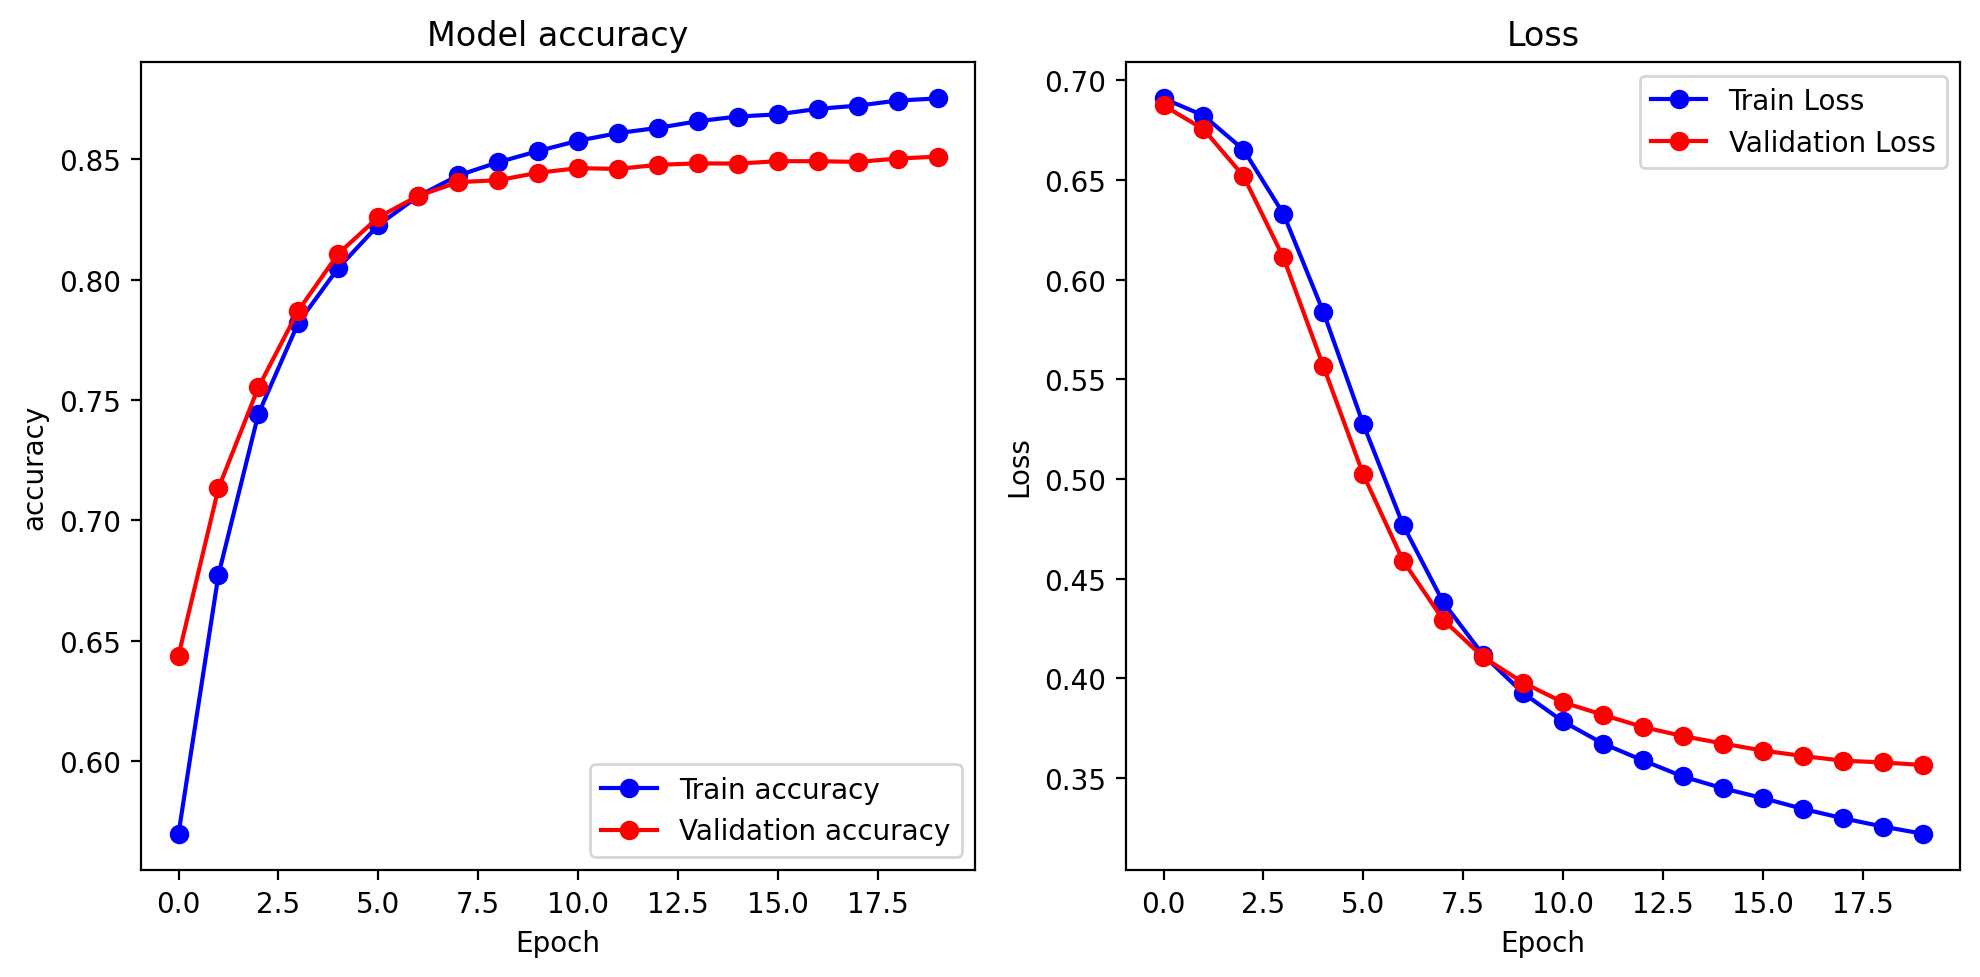

In [14]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 6-2 1-D CNN Model Evaluation

In [47]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 14s - loss: 0.9171 - accuracy: 0.8013 - 14s/epoch - 9ms/step
[0.91712886095047, 0.8012694120407104]


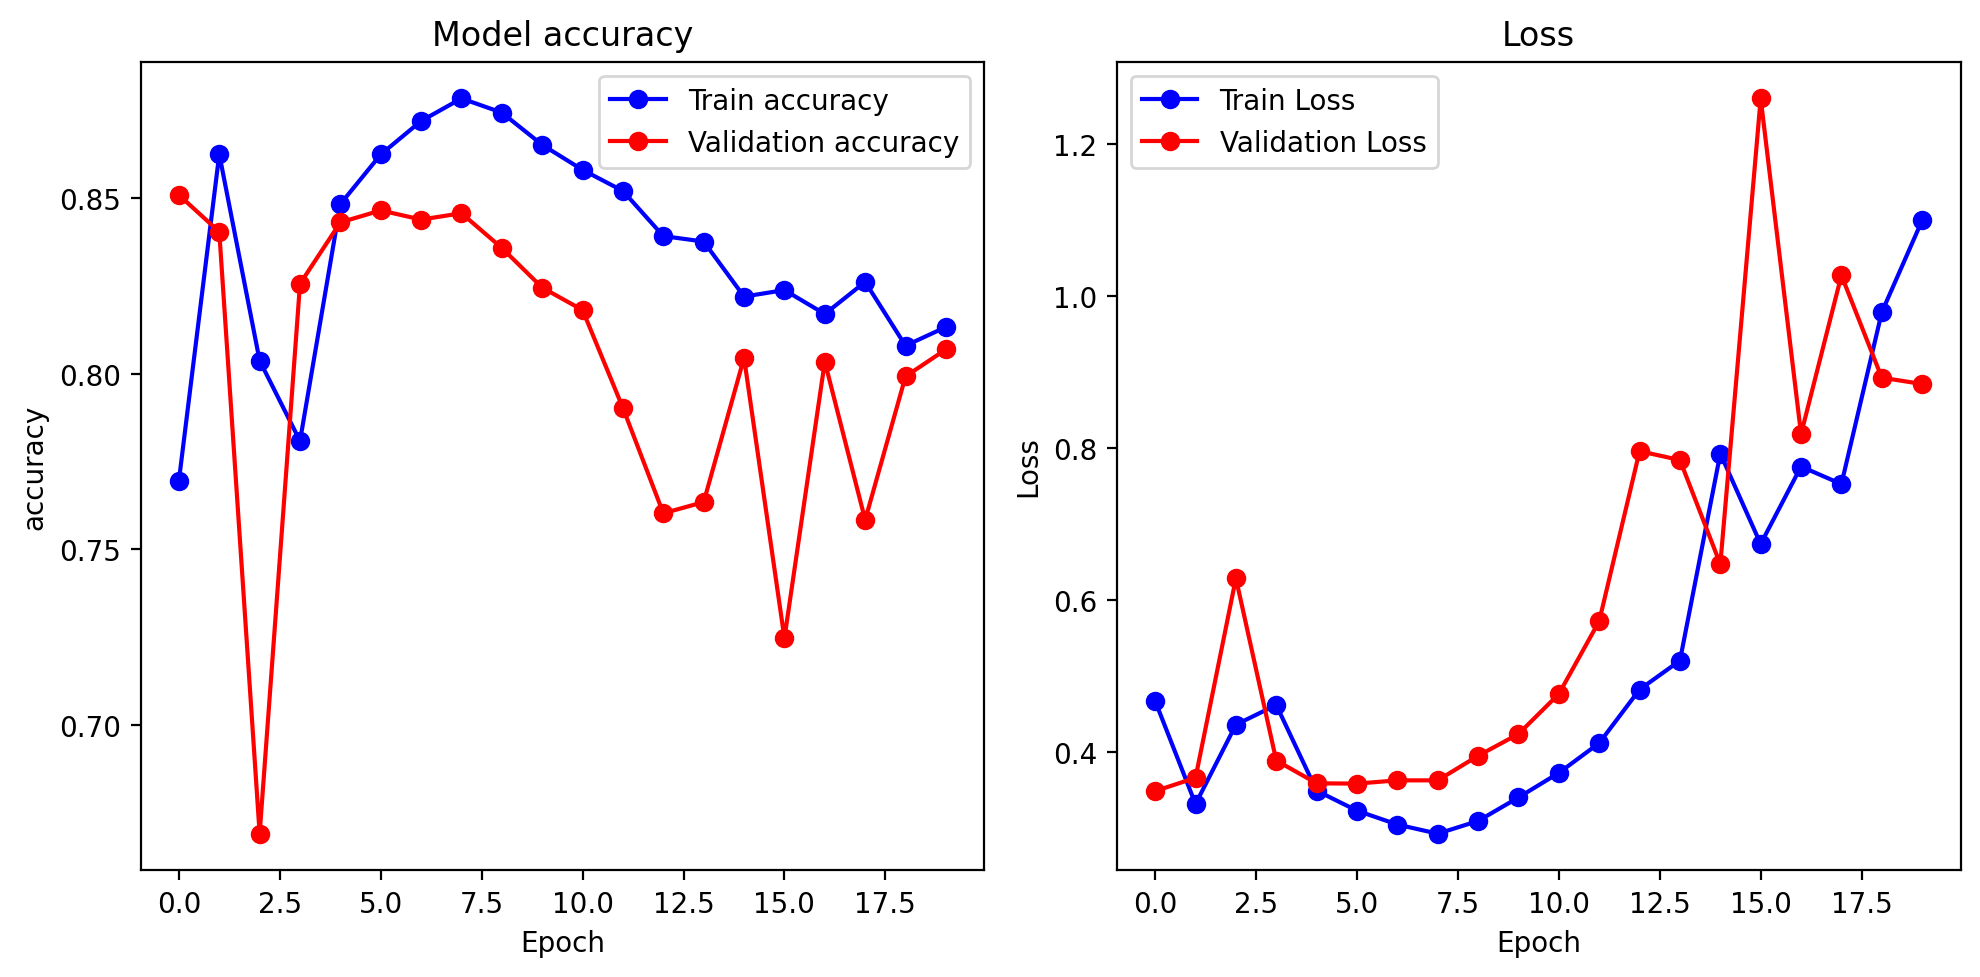

In [48]:
plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 6-3 Basic Evaluation

In [63]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 23s - loss: 0.5404 - accuracy: 0.8249 - 23s/epoch - 15ms/step
[0.5403752326965332, 0.8248672485351562]


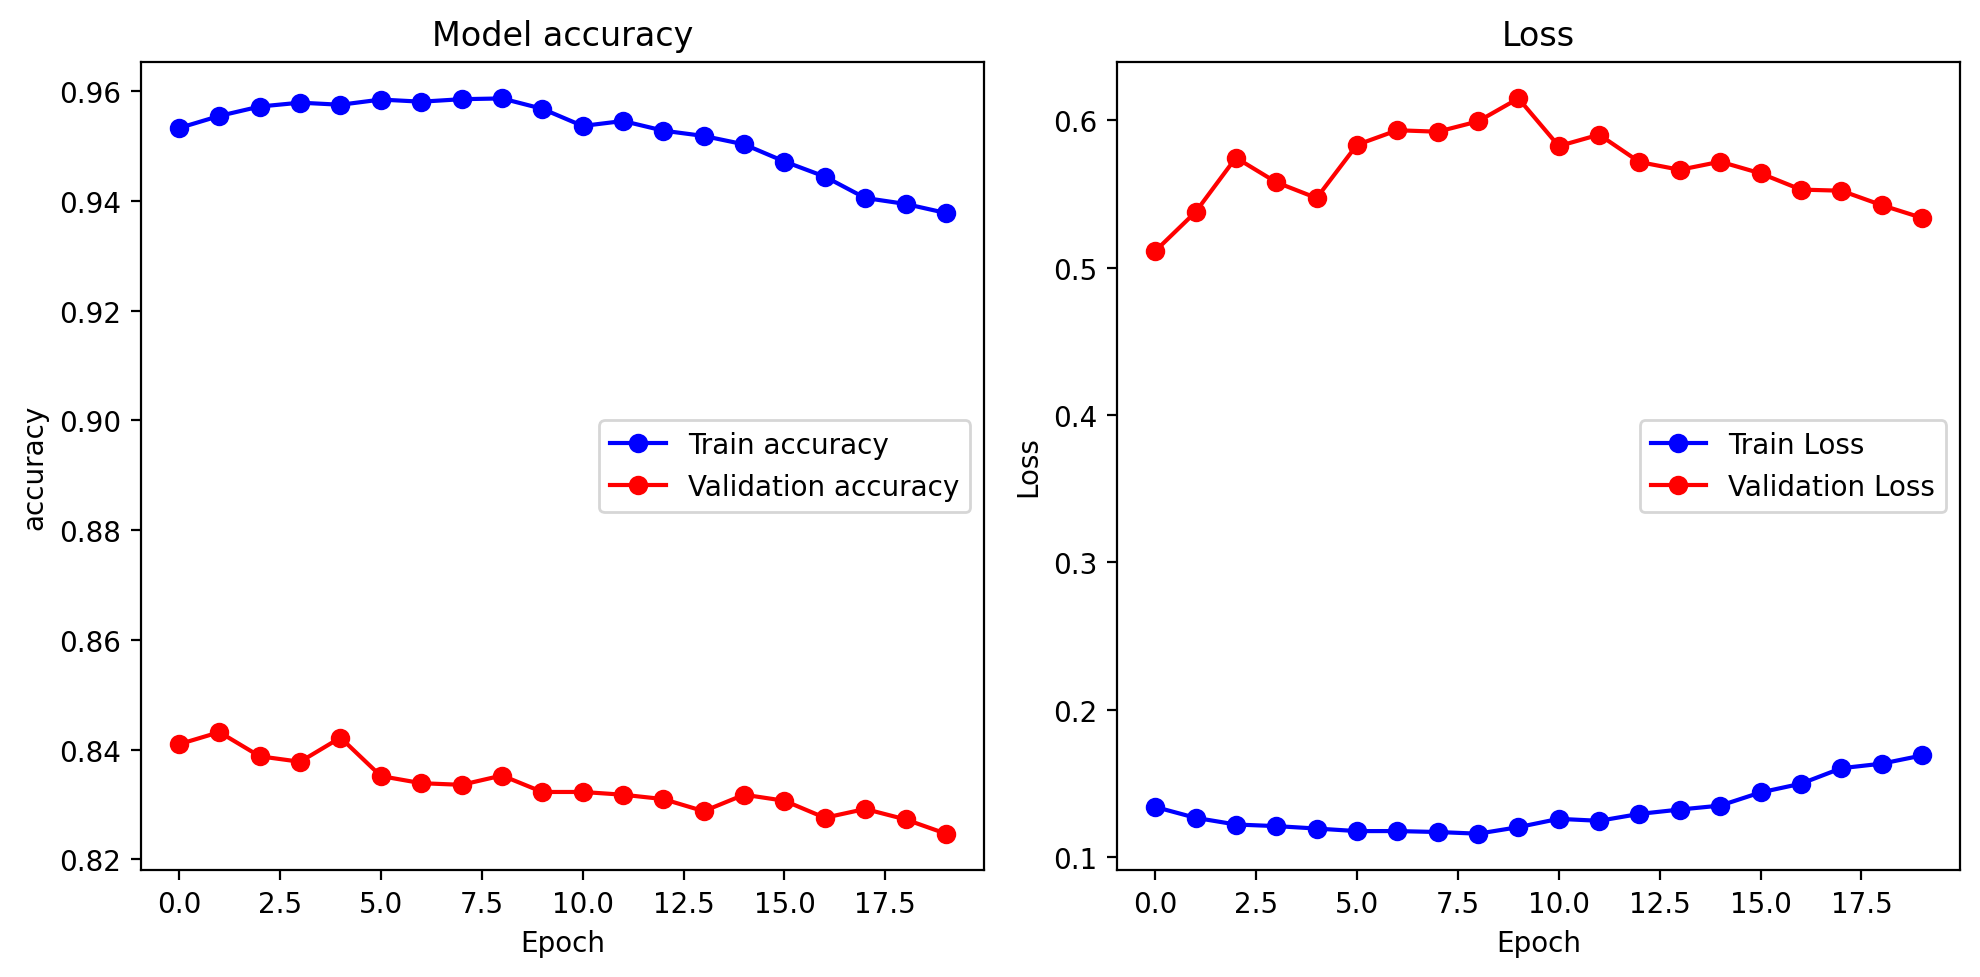

In [64]:
plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 7- word2vec

In [15]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [16]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/Users/kenny_jung/aiffel/data/sentiment_classification/word2vec_naver.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.00737171,  0.0713016 ,  0.03425064, -0.05939571, -0.09311027,
        0.01251853, -0.0150578 ,  0.0042496 ,  0.01898767,  0.05681619,
        0.04288032,  0.03505497,  0.07012589,  0.00480153, -0.06545478,
        0.07226989,  0.00976866,  0.08083999,  0.05490722,  0.00225829,
       -0.0293214 , -0.04227222, -0.06461433,  0.01480247, -0.04699061,
       -0.00734731,  0.08255826, -0.05549288, -0.00233316, -0.03930357,
       -0.08963127, -0.04758457,  0.0627474 ,  0.06369119, -0.01227271,
       -0.02791775,  0.08947808, -0.04777616,  0.03337345,  0.01714178,
        0.06663285,  0.03739984,  0.07087914, -0.04240117, -0.08953203,
        0.00480472, -0.02430966,  0.04293423, -0.05203241,  0.04316324,
        0.04367464,  0.04700666,  0.08755591, -0.07426275,  0.03341522,
       -0.02714301,  0.01308057,  0.02907701,  0.06056284,  0.00878059,
        0.01703484, -0.04530871,  0.03100535,  0.00911225, -0.02990479,
        0.01000635,  0.03865641,  0.00369462,  0.01408294, -0.04

# 8- word2vec_ko.model

In [10]:
from gensim.models import KeyedVectors
word2vec_path = '/Users/kenny_jung/aiffel/data/sentiment_classification/word2vec_ko.model'
word_vectors = KeyedVectors.load(word2vec_path)
vector = word_vectors.wv["끝"]
print(vector)

[ 1.038851   -1.1634965   2.2386286   0.8971453  -2.088168   -4.1942534
 -0.02519768 -0.69813883 -0.2908033  -1.4651134  -2.6863668   0.7999443
 -0.6957915  -0.5018775   3.5025773   0.21326113 -0.6588098  -1.1900496
  0.61399573  2.1247969   0.1549463   3.0840218   3.1680267  -3.9143991
  3.6073153   0.5315545  -0.3511633  -1.107248    1.7767181  -0.95981866
  2.6072454  -0.00697957 -3.27628     1.558644    0.81922376  1.9231955
  3.7026553  -0.53824735 -0.4920138   2.4657123  -2.620749   -0.08950733
  0.61453176  1.8866426   0.257866   -2.7827141   2.9129577  -0.6313133
  2.0387425  -4.222685   -2.7560544   1.7903243  -1.3080189  -2.5531402
 -0.43849912 -3.1073573  -0.29090825  5.1817617   1.9604833  -5.1421604
 -0.71431434  4.5624633  -0.55525815 -3.3019137   1.6761336  -1.9606539
 -0.2726863   0.2465995   1.2685091   1.6055685   1.8344896   1.2752469
  0.99503314 -2.3348706  -0.9290329  -1.5920266   5.693834    1.1132814
 -0.9603875  -1.970055   -1.0120267  -2.7289615  -2.7759619   

In [11]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066587805747986),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [13]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 35, 16)            11216     
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 16)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d (Glob  (None, 16)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 8)                 1

2024-03-23 09:42:58.246231: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-23 09:42:58.246254: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-23 09:42:58.246261: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-23 09:42:58.246295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-23 09:42:58.246310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
epochs=20

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20


2024-03-23 09:43:07.563862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-23 09:43:07.611010: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


266/266 [==============================] - 30s 110ms/step - loss: 0.7072 - accuracy: 0.5189 - val_loss: 0.6895 - val_accuracy: 0.5370
Epoch 2/20
266/266 [==============================] - 28s 105ms/step - loss: 0.6542 - accuracy: 0.6099 - val_loss: 0.6209 - val_accuracy: 0.6554
Epoch 3/20
266/266 [==============================] - 28s 105ms/step - loss: 0.5890 - accuracy: 0.6890 - val_loss: 0.5737 - val_accuracy: 0.7067
Epoch 4/20
266/266 [==============================] - 28s 105ms/step - loss: 0.5495 - accuracy: 0.7235 - val_loss: 0.5466 - val_accuracy: 0.7270
Epoch 5/20
266/266 [==============================] - 28s 104ms/step - loss: 0.5255 - accuracy: 0.7421 - val_loss: 0.5272 - val_accuracy: 0.7410
Epoch 6/20
266/266 [==============================] - 28s 104ms/step - loss: 0.5078 - accuracy: 0.7555 - val_loss: 0.5137 - val_accuracy: 0.7508
Epoch 7/20
266/266 [==============================] - 28s 106ms/step - loss: 0.4942 - accuracy: 0.7654 - val_loss: 0.5026 - val_accuracy: 0.7

In [16]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 8s - loss: 0.4663 - accuracy: 0.7857 - 8s/epoch - 5ms/step
[0.46625491976737976, 0.7856663465499878]


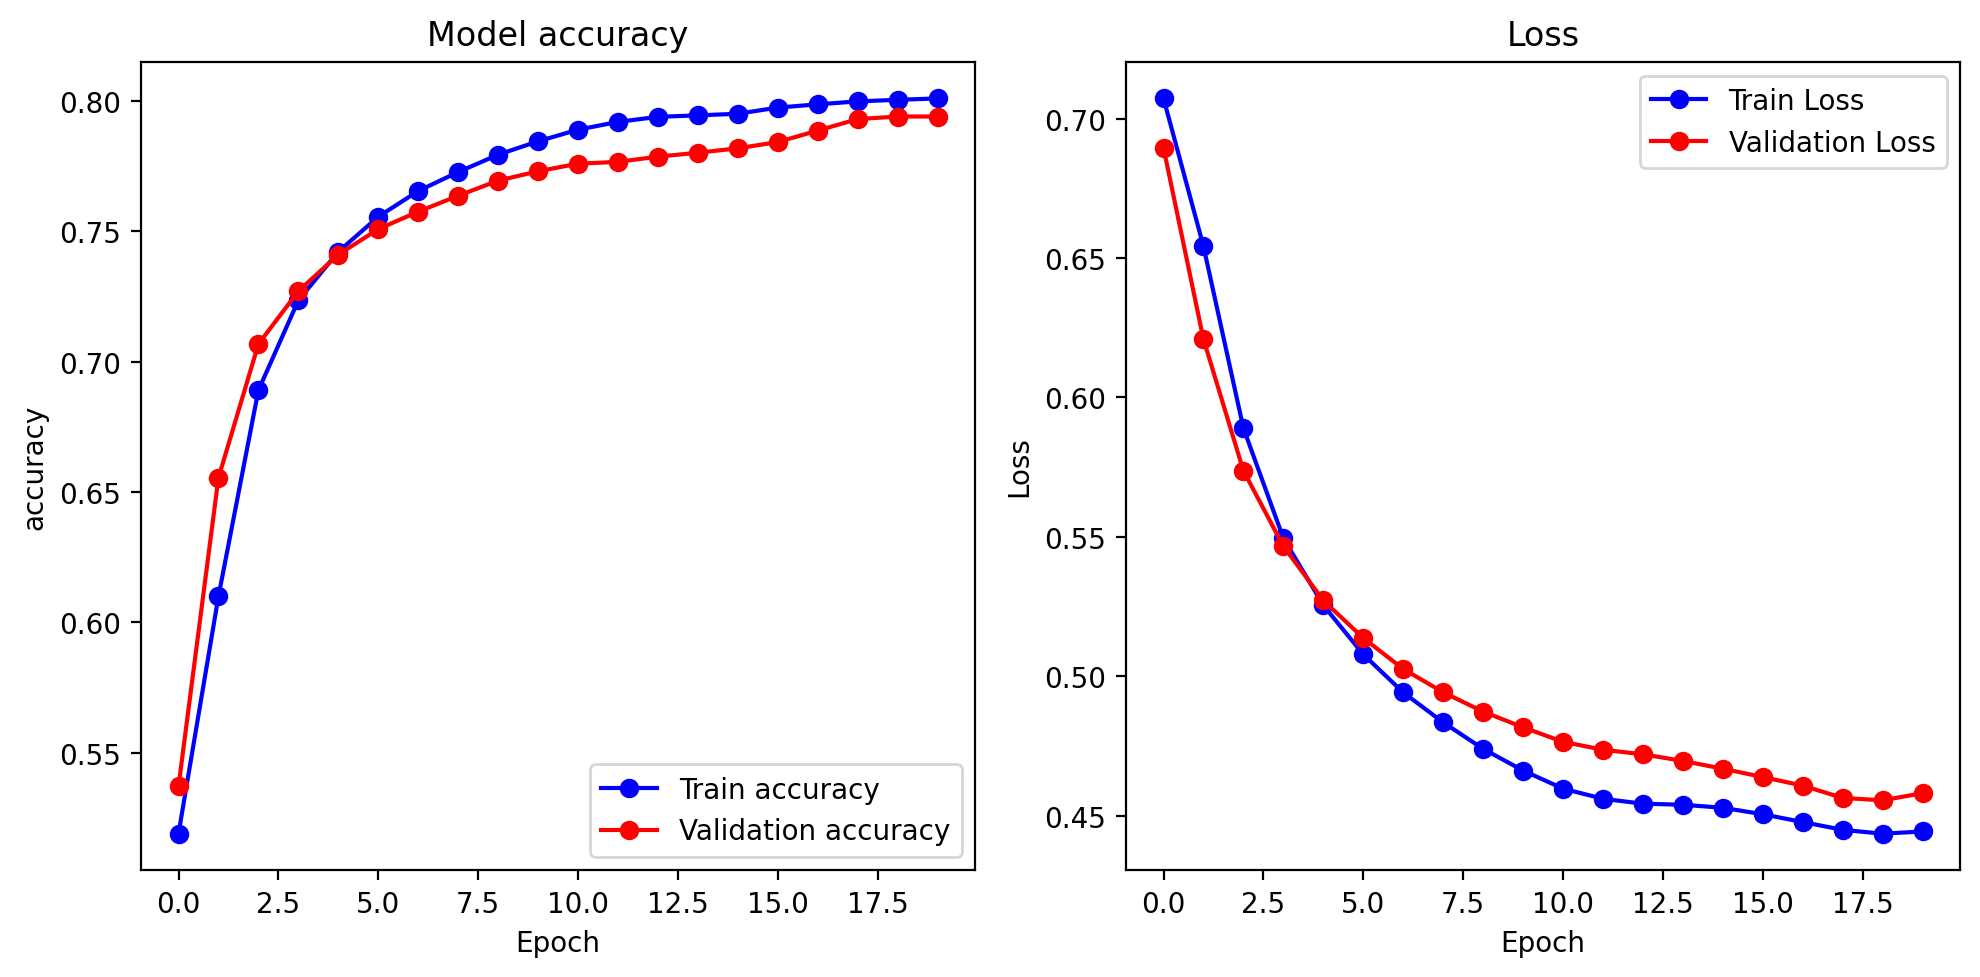

In [17]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='red', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#

# 9- Retrospective

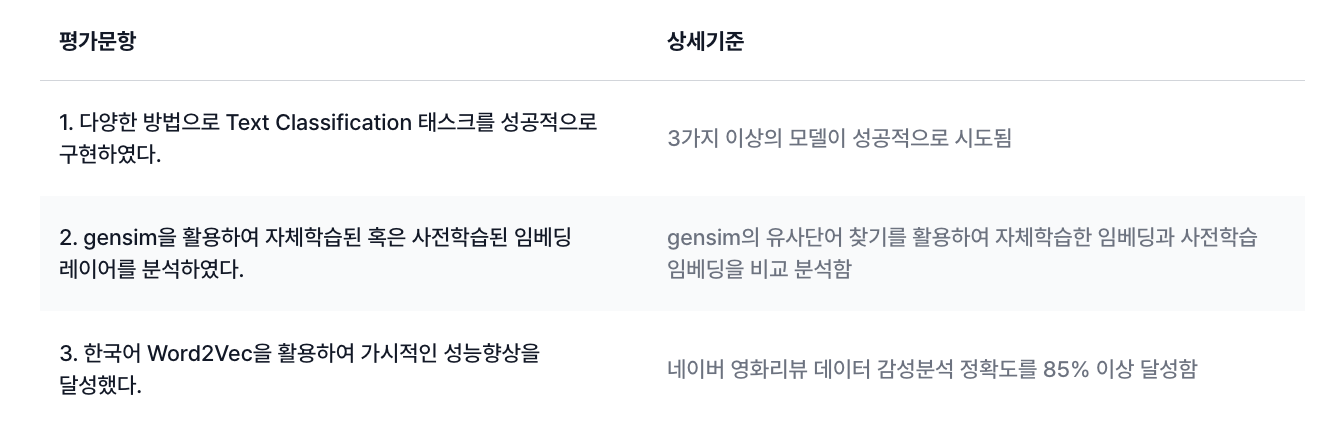